# Где дешевле жить? Предсказание цен в AirBnb

how to visualize - https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data?resource=download  

Импортируем нужные библиотеки и прочитаем данные.  

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.shape

(48895, 16)

Посмотрим на данные.  

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


Можно сразу выкинуть признаки, которые нам не помогут в данном задании.  

In [5]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)

Посмотрим на пропущенные значения.  

In [6]:
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
df.dropna().shape[0] / df.shape[0]

0.7944166070150323

Пропуски есть только в одном признаке и их довольно много. Разберёмся, что можно с этим сделать.  

In [8]:
df['reviews_per_month'].corr(df['price'])

-0.030608348567533108

Корреляция с целевой переменной отсутствует. Посмотрим подробнее, что это за признак.  

In [9]:
df.loc[df['reviews_per_month'].isna()]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
19,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,2,249
26,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,1,0
36,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,1,365
38,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,6,2


Кажется, есть взаимосвязь между `number_of_reviews` = 0 и `reviews_per_month` = NaN.  
Чтобы убедиться что это действительно так, попробуем найти случаи, когда `number_of_reviews` != 0 и `reviews_per_month` = NaN.  

In [10]:
df.loc[(df['reviews_per_month'].isna()) & (df['number_of_reviews'] != 0)]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365


Таких случаев нет, значит гипотеза верна. Следовательно, пропуски стоит заполнить так же нулями.

In [11]:
df['reviews_per_month'].fillna(0, inplace=True)

Посмотрим, какие типы признаков есть.  

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               48895 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


Посмотрим на статистики некатегориальных признаков.  

In [13]:
cols = [
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]
df[cols].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Видно, что в `price` и `minimum_nights` есть выбросы.  
`price` - при среднем 152, медиане 106 и отклонении 240 максимальное значение 10000 и минимальное 0.  
`minimum_nights` - при среднем 7 и медиане 5 отклонение 20 и максимальное значение 1250.  

Посмотрим на корреляцию между признаками, и что с ней произойдет после обработки выбросов.  

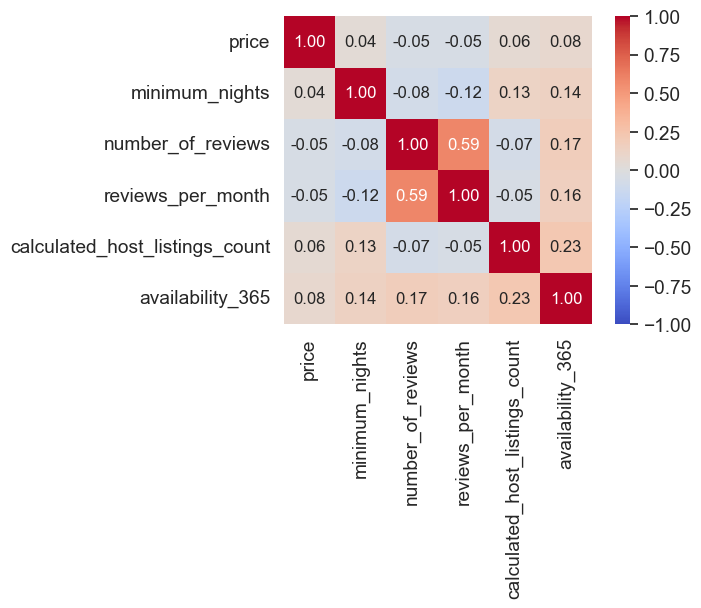

In [14]:
cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.25)
sns.heatmap(
    cm, cbar=True, annot=True,
    square=True, fmt='.2f', annot_kws={'size': 12},
    yticklabels=cols, xticklabels=cols, vmin=-1, center=0,
    cmap=sns.color_palette('coolwarm', 1000)
)
plt.show()

Как изменятся статистики, если удалить выбросы?  

**1) Price**

In [15]:
df['price'].quantile(0.99)

799.0

In [16]:
len(df.loc[df['price'] > 799])

474

In [17]:
df[cols].loc[(df['price'] <= 799) & (df['price'] != 0)].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48410.000000,48410.000000,48410.000000,48410.000000,48410.000000,48410.000000
mean,137.575170,6.979508,23.412663,1.096716,7.179860,112.094195
std,103.780081,20.293249,44.700109,1.601074,33.094503,131.258152
min,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,105.000000,3.000000,5.000000,0.380000,1.000000,44.000000
75%,175.000000,5.000000,24.000000,1.600000,2.000000,224.000000
max,799.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


**2) Minimum nights**  

In [18]:
df['minimum_nights'].quantile(0.99)

45.0

In [19]:
df['minimum_nights'].quantile(0.98)

30.0

In [20]:
len(df.loc[df['minimum_nights'] > 30])

747

In [21]:
df[cols].loc[df['minimum_nights'] <= 30].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48148.000000,48148.000000,48148.000000,48148.000000,48148.000000,48148.000000
mean,151.384211,5.579692,23.468638,1.102973,7.144471,111.732097
std,226.164432,8.203838,44.719261,1.604667,33.050749,131.231712
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,105.000000,2.000000,5.000000,0.380000,1.000000,43.000000
75%,175.000000,5.000000,24.000000,1.620000,2.000000,224.000000
max,10000.000000,30.000000,629.000000,58.500000,327.000000,365.000000


Улучшилась ли корреляция?

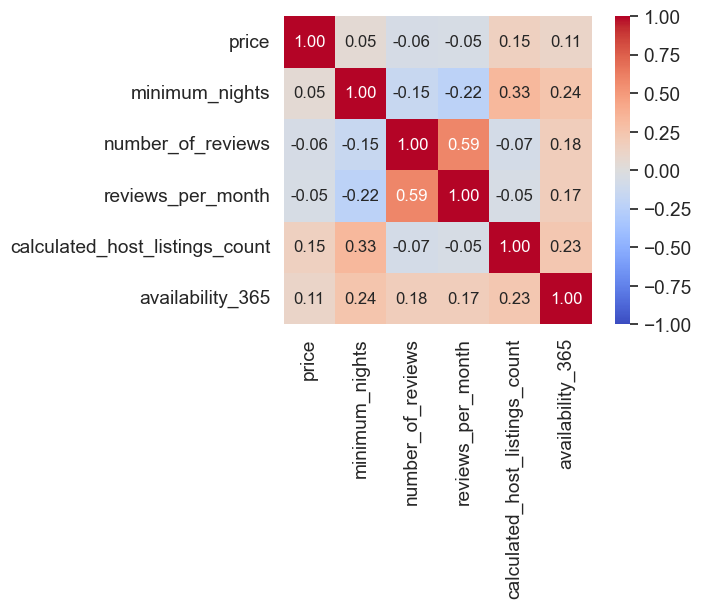

In [22]:
cm = np.corrcoef(df[cols].loc[(df['price'] <= 799) & (df['price'] != 0) & (df['minimum_nights'] <= 30)].values.T)
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.25)
sns.heatmap(
    cm, cbar=True, annot=True,
    square=True, fmt='.2f', annot_kws={'size': 12},
    yticklabels=cols, xticklabels=cols, vmin=-1, center=0,
    cmap=sns.color_palette('coolwarm', 1000)
)
plt.show()

In [23]:
df.loc[(df['price'] <= 799) & (df['price'] != 0) & (df['minimum_nights'] <= 30)].shape[0] / df.shape[0]

0.9753962572860211

In [24]:
df = df.loc[(df['price'] <= 799) & (df['price'] != 0) & (df['minimum_nights'] <= 30)]
df.reset_index(inplace=True)

В итоге, избавились от выбросов и улучшили корреляцию, потеряв всего 2.5% данных. Теперь посмотрим на графики.  

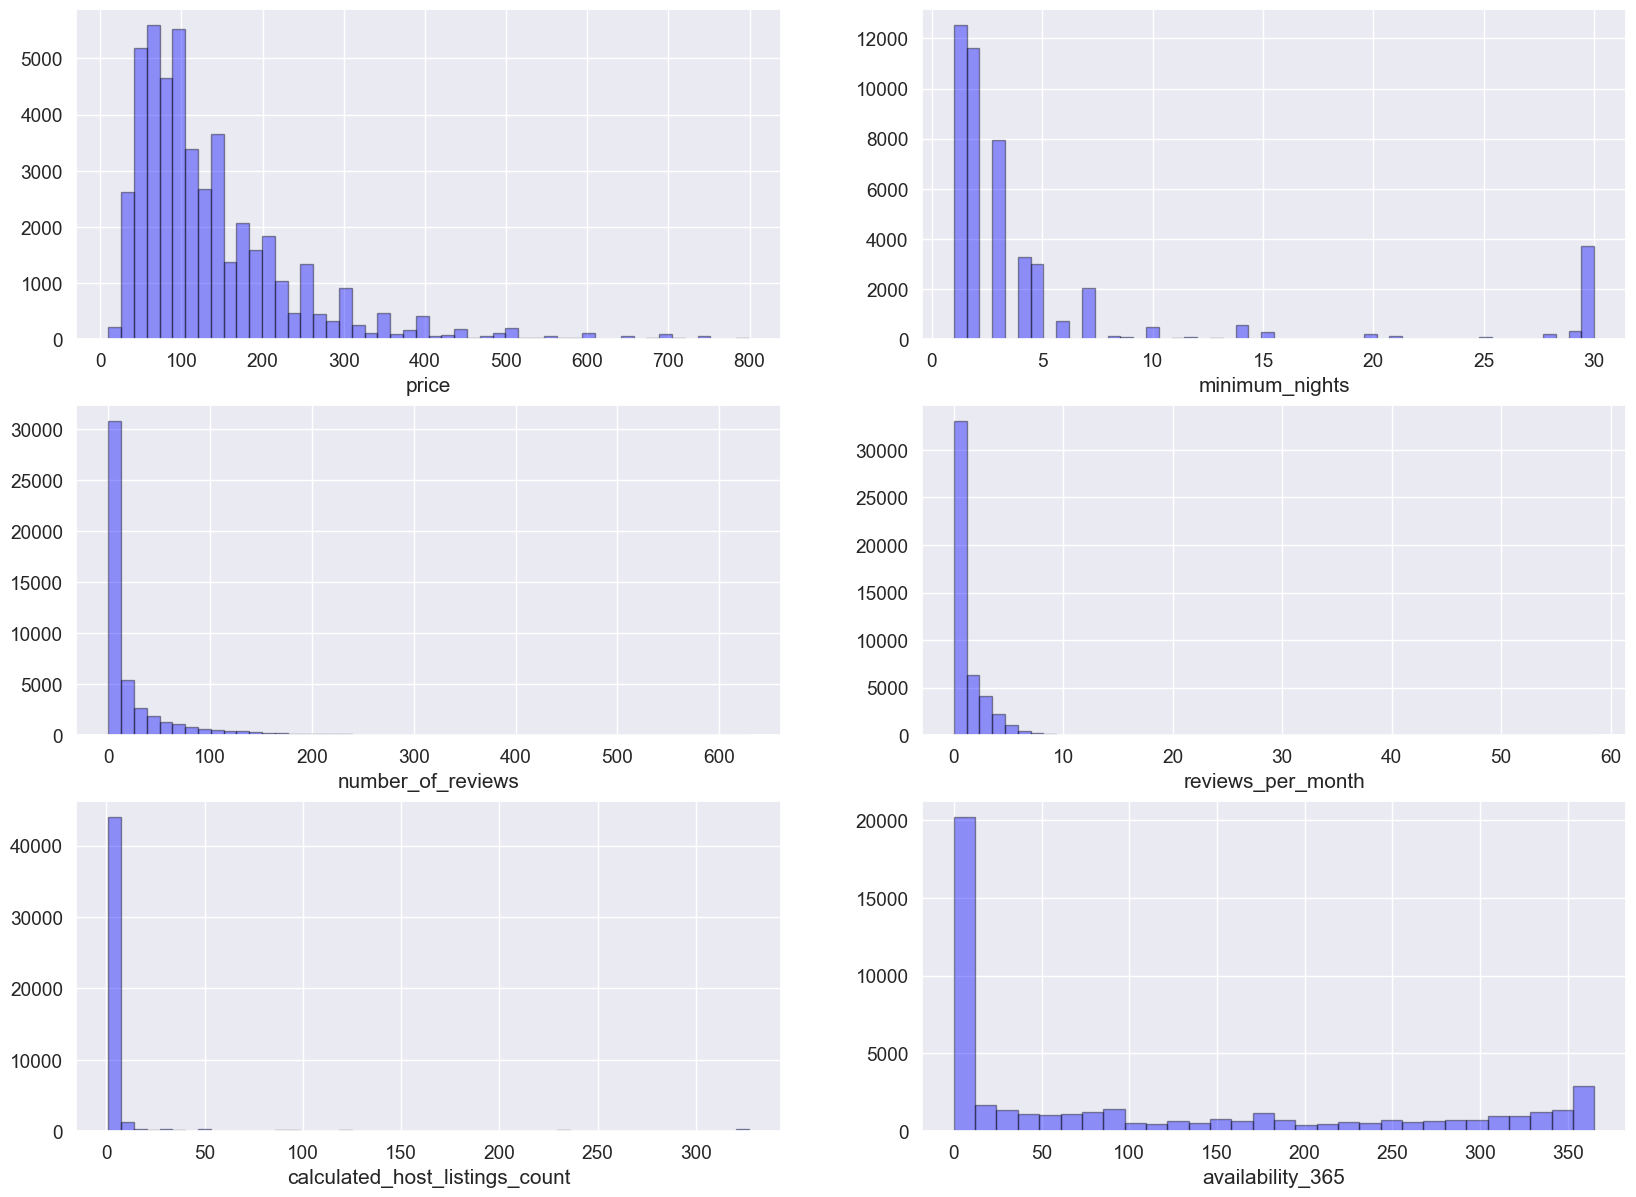

In [25]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(cols):
    
    plt.subplot(6, 2, i+1)
    
    sns.distplot(
        df[col],
        hist=True,
        kde=False,
        color='blue',
        hist_kws={'edgecolor': 'black'}
    )

plt.show()

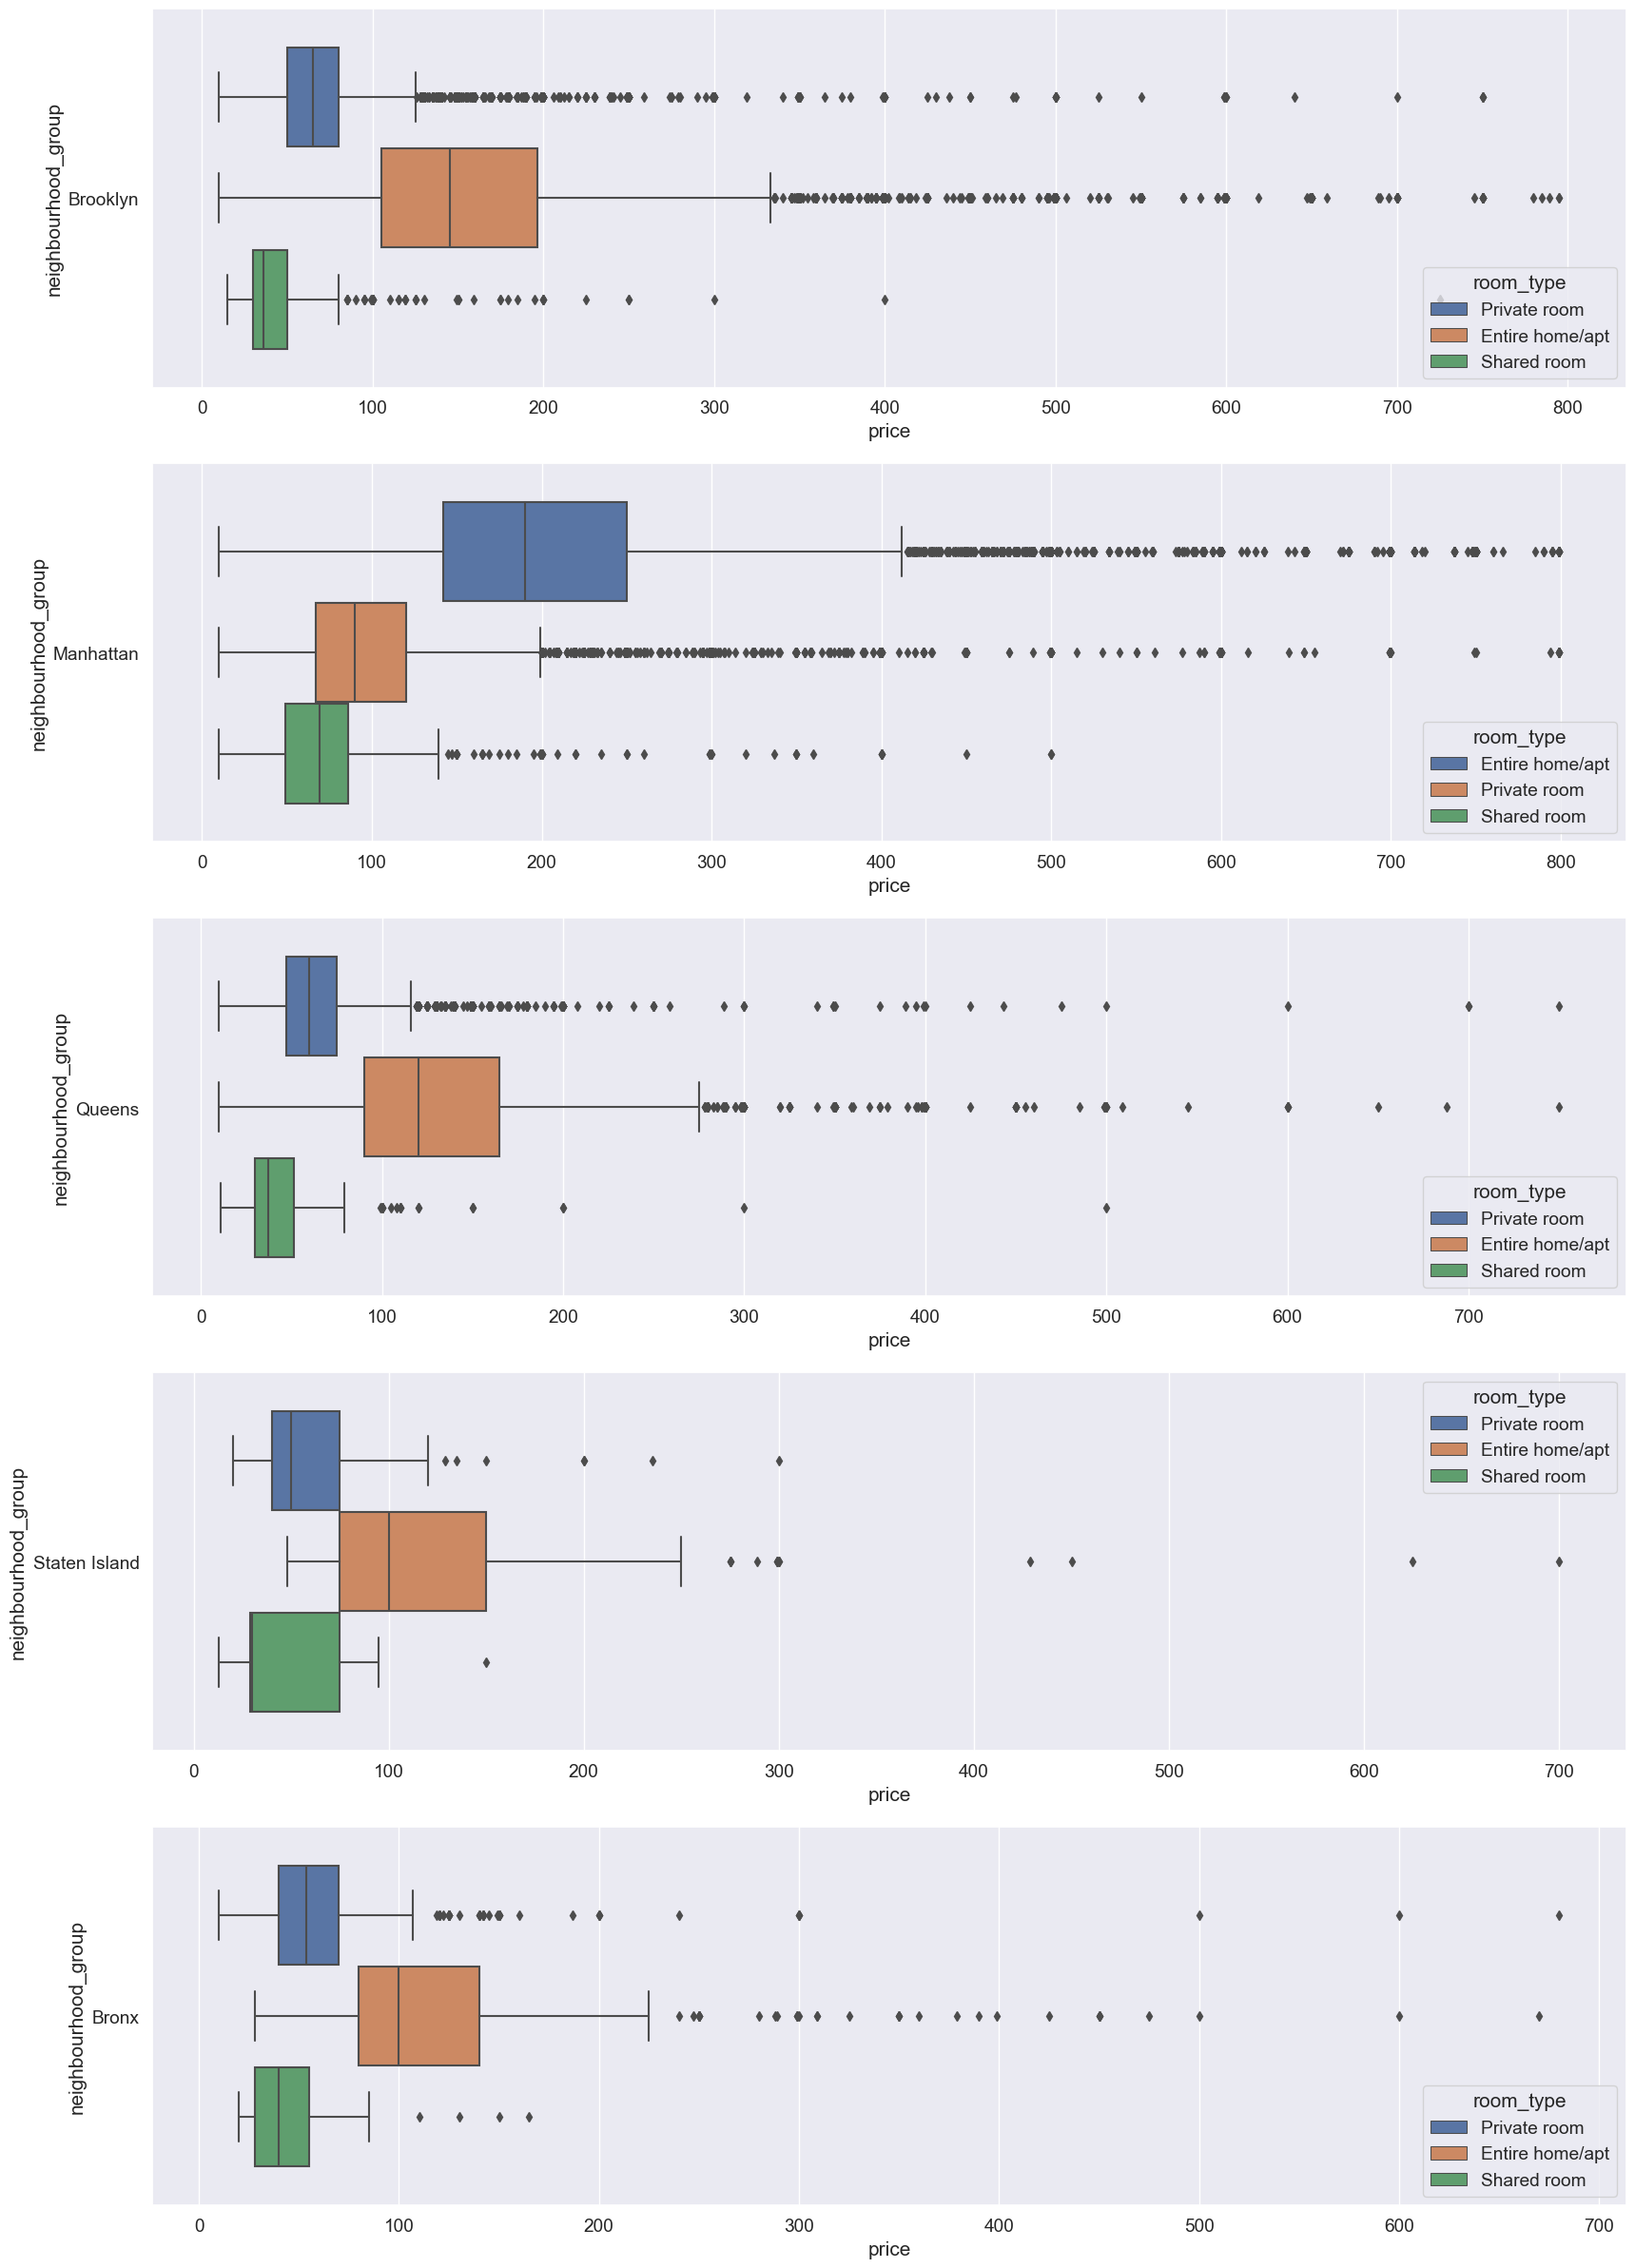

In [26]:
groups = pd.unique(df['neighbourhood_group'])

plt.figure(figsize=(20, 30))

for i, group in enumerate(groups):
    
    plt.subplot(5, 1, i+1)
    
    sns.boxplot(
        x=df['price'].loc[df['neighbourhood_group'] == group],
        y=df['neighbourhood_group'].loc[df['neighbourhood_group'] == group],
        hue=df['room_type'].loc[df['neighbourhood_group'] == group]
    )
    
plt.show()

Займемся масштабированием данных, и т.к. у нас еще остались хвосты в признаках, думал, что стоит использовать RobustScaler.  
Но опытном путем выяснил, что при использовании StandardScaled, модели дают лучшее качество.  

In [27]:
numerical_features = [c for c in cols if c != 'price']
rs = StandardScaler()
robust_scaled = pd.DataFrame(rs.fit_transform(df[numerical_features]), columns=numerical_features)
robust_scaled.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.769200e+04,4.769200e+04,4.769200e+04,4.769200e+04,4.769200e+04
mean,-1.107538e-15,-1.166391e-14,2.261348e-14,-4.144244e-15,1.866407e-14
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-5.586460e-01,-5.260459e-01,-6.892181e-01,-1.862491e-01,-8.487235e-01
25%,-5.586460e-01,-5.037547e-01,-6.581280e-01,-1.862491e-01,-8.487235e-01
50%,-4.366729e-01,-4.145897e-01,-4.467155e-01,-1.862491e-01,-5.278320e-01
75%,-7.075369e-02,8.943696e-03,3.243184e-01,-1.561228e-01,8.397769e-01
max,2.978573e+00,1.349514e+01,3.568617e+01,9.634929e+00,1.939976e+00


Видим 3 категориальных признака. Посмотрим, какой кодировщик лучше подойдет.  

In [28]:
print(df['neighbourhood_group'].unique())
print(df['neighbourhood'].unique())
print(df['room_type'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' "Hell's Kitchen" 'Upper West Side' 'Chinatown'
 'South Slope' 'Williamsburg' 'Fort Greene' 'Chelsea' 'Crown Heights'
 'Park Slope' 'Bedford-Stuyvesant' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Carroll Gardens' 'West Village' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason Point' 'Eastchester' 'Kingsbridge'
 'Brooklyn Heights' 'Two Bridges' 'Queens Village' 'Rockaway Beach'


- Признаки не упорядочены, значит точно не OrdinaryEncoder.  
- В документации sklearn сказано, что LabelEncoder рекомендуется использовать только для целевой переменной, поэтому тоже отпадает.  
- OneHotEncoder сюда подойдет, но его я бы тоже применять не стал, т.к. есть более оптимальный вариант в виде BinaryEncoder. Ожидаю, что эффект от кодирования им будет не хуже, и заодно в трансформированном датасете получится меньше столбцов.  

In [29]:
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
ce_bin = BinaryEncoder(cols=categorical_features)
encoded_features = ce_bin.fit_transform(df[categorical_features])
encoded_features.head()

,neighbourhood_group_0,neighbourhood_group_1,neighbourhood_group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7,room_type_0,room_type_1
0,0,0,1,0,0,0,0,0,0,0,1,0,1
1,0,1,0,0,0,0,0,0,0,1,0,1,0
2,0,1,0,0,0,0,0,0,0,1,1,0,1
3,0,0,1,0,0,0,0,0,1,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0,1,1,0


Из `latitude` и `longitude` можно сделать признак - расстояние до какого-нибудь ключевого пункта. Например, центра самого дорогого района, центра района, в котором расположены апартаменты, центра города или аэропорта Кэннеди.

In [30]:
groups_coord = {
    'Brooklyn': [40.650002, -73.949997],
    'Manhattan': [40.7834, -73.9662],
    'Queens': [40.742054, -73.769417],
    'Staten Island': [40.579021, -74.151535],
    'Bronx': [40.8498, -73.8664],
    'New York': [40.7143, -74.006],
    'Airport': [40.641766, -73.780968]
}

def calc_geo_dist(lat, lon, group):
    R = 6373.0
    lat_m = radians(groups_coord[group][0])
    lon_m = radians(groups_coord[group][1])
    
    lat = radians(lat)
    lon = radians(lon)
    
    dlat = lat - lat_m
    dlon = lon - lon_m
    
    a = sin(dlat / 2)**2 + cos(lat_m) * cos(lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    return distance

Посмотрим, как целевая переменная коррелирует с центром Манхэттена.

In [31]:
geo_dist = []
for i in range(df.shape[0]):
    dist = calc_geo_dist(df['latitude'].values[i], df['longitude'].values[i], 'Manhattan')
    geo_dist.append(dist)

geo_dist = np.array(geo_dist)

np.corrcoef(df['price'].values, geo_dist)[0, 1]

-0.23274536163226156

Теперь посмотрим на корреляцию с центром района.

In [32]:
geo_dist = []
for i in range(df.shape[0]):
    dist = calc_geo_dist(df['latitude'].values[i], df['longitude'].values[i], df['neighbourhood_group'].values[i])
    geo_dist.append(dist)

geo_dist = np.array(geo_dist)

np.corrcoef(df['price'].values, geo_dist)[0, 1]

-0.06976914046388065

Центр Нью-Йорка.

In [33]:
geo_dist = []
for i in range(df.shape[0]):
    dist = calc_geo_dist(df['latitude'].values[i], df['longitude'].values[i], 'New York')
    geo_dist.append(dist)

geo_dist = np.array(geo_dist)

np.corrcoef(df['price'].values, geo_dist)[0, 1]

-0.28601549034605417

И последнее - аэропорт Кеннеди.

In [34]:
geo_dist = []
for i in range(df.shape[0]):
    dist = calc_geo_dist(df['latitude'].values[i], df['longitude'].values[i], 'Airport')
    geo_dist.append(dist)

geo_dist = np.array(geo_dist)

np.corrcoef(df['price'].values, geo_dist)[0, 1]

0.19300056881770197

Как видно, расстояние до аэропорта сильнее влияет на цену апартаментов.

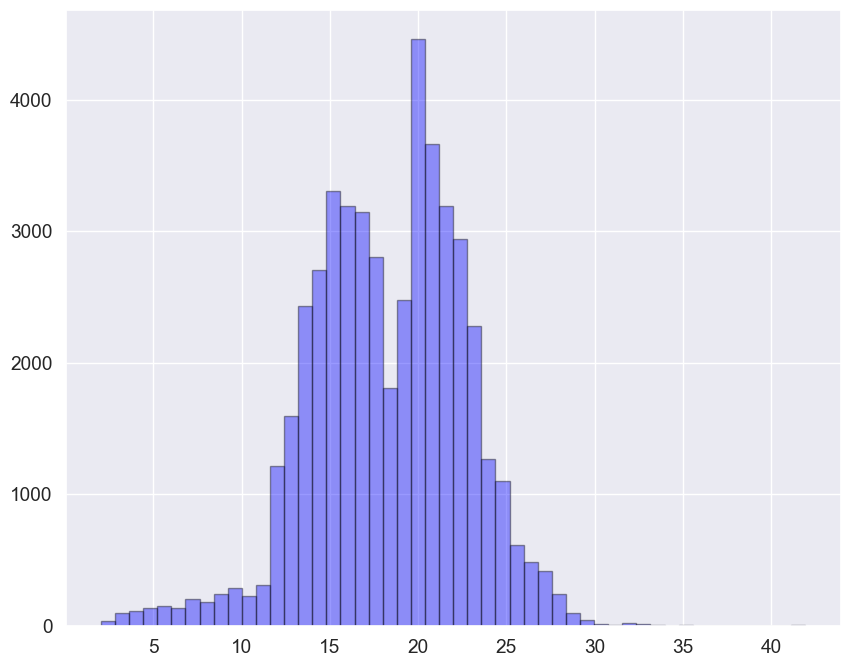

In [35]:
plt.figure(figsize=(10, 8))
    
sns.distplot(
    geo_dist,
    hist=True,
    kde=False,
    color='blue',
    hist_kws={'edgecolor': 'black'}
)

plt.show()

И распределение похоже на нормальное :)

In [36]:
scaled_geo_dist = pd.DataFrame(data=rs.fit_transform(geo_dist.reshape((len(geo_dist), 1))), columns=['geo_dist'])
scaled_geo_dist.head()

,geo_dist
0,-0.487596
1,0.656870
2,1.087643
3,-0.563016
4,0.898257


Собираем наш обработанный датафрейм и разделяем на train и test.  

In [37]:
df_processed = pd.concat([robust_scaled, encoded_features, scaled_geo_dist, df['price']], axis=1)
df_processed.shape

(47692, 20)

In [38]:
df_processed.isna().sum()

minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_group_0             0
neighbourhood_group_1             0
neighbourhood_group_2             0
neighbourhood_0                   0
neighbourhood_1                   0
neighbourhood_2                   0
neighbourhood_3                   0
neighbourhood_4                   0
neighbourhood_5                   0
neighbourhood_6                   0
neighbourhood_7                   0
room_type_0                       0
room_type_1                       0
geo_dist                          0
price                             0
dtype: int64

In [39]:
y_column = 'price'
X_columns = df_processed.drop(columns=['price']).columns
X_columns

Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_0', 'neighbourhood_group_1',
       'neighbourhood_group_2', 'neighbourhood_0', 'neighbourhood_1',
       'neighbourhood_2', 'neighbourhood_3', 'neighbourhood_4',
       'neighbourhood_5', 'neighbourhood_6', 'neighbourhood_7', 'room_type_0',
       'room_type_1', 'geo_dist'],
      dtype='object')

In [40]:
X = df_processed[X_columns]
y = df_processed[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [41]:
def quality(pred_y, true_y):
    rmse = mean_squared_error(true_y, pred_y, squared=False)
    mae = mean_absolute_error(true_y, pred_y)
    r2 = r2_score(true_y, pred_y)
    print(f'RMSE: {round(rmse, 3)}')
    print(f'MAE: {round(mae, 3)}')
    print(f'R2: {round(r2, 3)}')

Попробуем обучить модели регрессии.  

**1) Linear regression**

In [42]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

<AxesSubplot:>

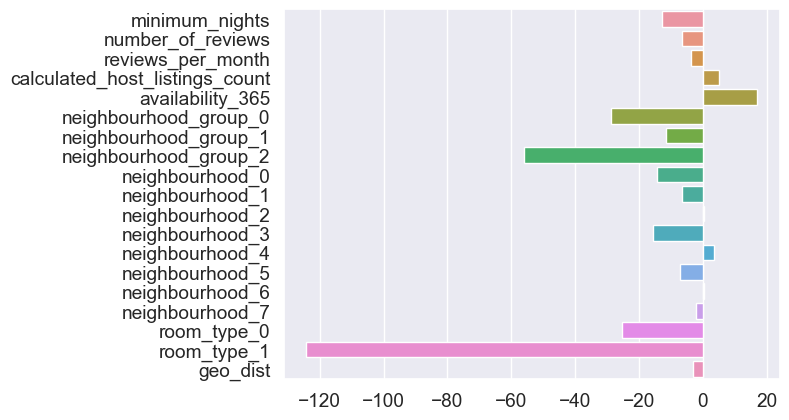

In [43]:
sns.barplot(x=linreg.coef_, y=X_columns)

In [44]:
linreg_y_pred = linreg.predict(X_test)
quality(linreg_y_pred, y_test)

RMSE: 85.309
MAE: 53.753
R2: 0.352


**2) Ridge**  

In [45]:
ridge = RidgeCV()
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

<AxesSubplot:>

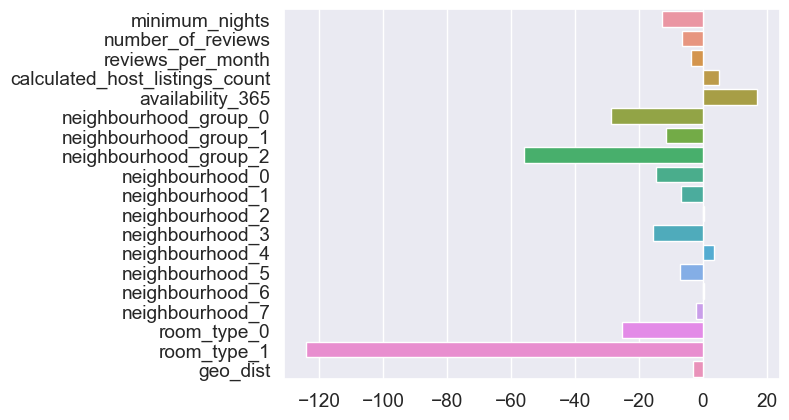

In [46]:
sns.barplot(x=ridge.coef_, y=X_columns)

In [47]:
ridge_y_pred = ridge.predict(X_test)
quality(ridge_y_pred, y_test)

RMSE: 85.309
MAE: 53.753
R2: 0.352


**3) Lasso**

In [48]:
lasso = LassoCV()
lasso.fit(X_train, y_train)

LassoCV()

<AxesSubplot:>

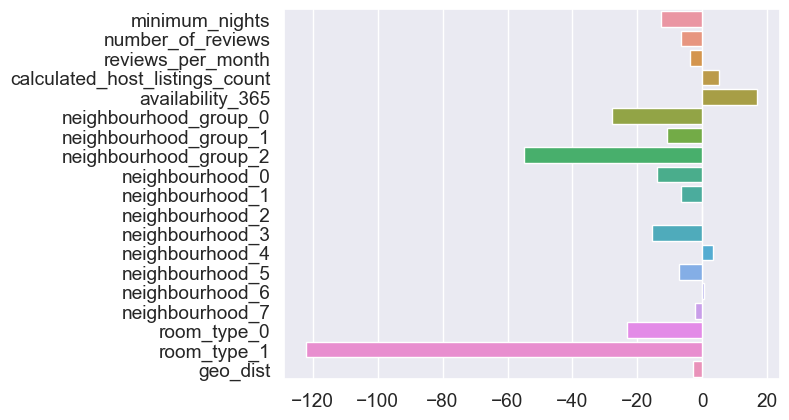

In [49]:
sns.barplot(x=lasso.coef_, y=X_columns)

In [50]:
lasso_y_pred = lasso.predict(X_test)
quality(lasso_y_pred, y_test)

RMSE: 85.315
MAE: 53.726
R2: 0.352


**4) ElasticNet**

In [51]:
elnet = ElasticNetCV()
elnet.fit(X_train, y_train)

ElasticNetCV()

<AxesSubplot:>

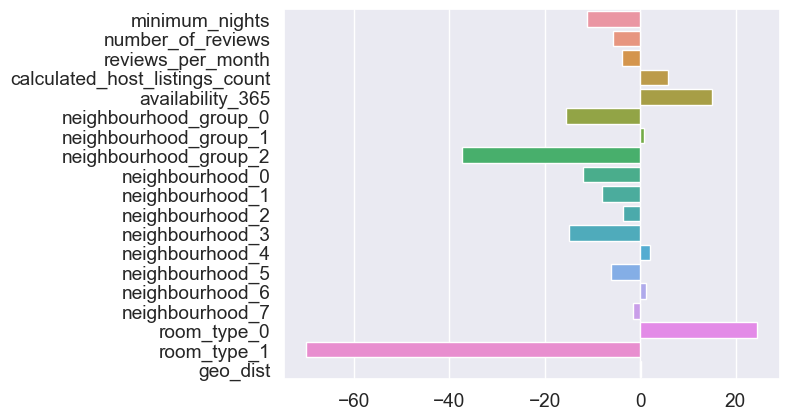

In [52]:
sns.barplot(x=elnet.coef_, y=X_columns)

In [53]:
elnet_y_pred = elnet.predict(X_test)
quality(elnet_y_pred, y_test)

RMSE: 85.972
MAE: 53.903
R2: 0.342


R2 - далек от 1 - плохо.
MAE - можно сказать, что в среднем модели ошибаются на 53 доллара в предсказании цены - ужасно)
RMSE - как и остальные 2 метрики, показывает, что модели справляются плохо.

1) Пробовал убирать выбросы из всех некатегориальных признаков - положительного эффекта не было.  
2) Пробовал разные кодировщики для категорий - лучший был у OHE, но не сильно от него отставал BinaryEncoder. Решил использовать его, т.к. интерпретируемость признаков особо не теряется, и датасет не разбухает в ширину.  
3) Пробовал разные методы нормирования данных - ожидал, что лучший прирост качества моделей будет с RobustScaler, но на первом месте оказался StandardScaler.  
4) Добавил новую переменную, которая входит в топ коррелирующих с целевой - Расстояние до аэропорта.

Полученные модели показывают не очень хорошее качество. Почему так?  
Думаю, из-за того, что признаки имеют слабую корреляцию с целевой переменной, не получается достичь удовлетворительных результатов.  